# Overview

This notebook examines some [thermal shift assay](https://en.wikipedia.org/wiki/Thermal_shift_assay) data obtained by S. Sirk at the ChEM-H Macromolecular Structure Knowledge Center at Stanford University.

## Background

In the thermal shift dye-binding assay, a solution of pure protein at a low temperature (~ 4 &deg;C) is incubated with a fluorescent dye.  The solution is slowly ramped up, warming the protein.  The fluorescence of the dye is monitored as a function of temperature.  When the protein is thermally denatured, hydrophobic regions int the protein's core are exposed to the solution, allowing dye binding and increasing fluorescence.  Eventually, the partially denatured protein becomes saturated with dye. At very high temperatures, fully denatured proteins can interact with themselves, displacing bound dye, resulting in a decrease in fluorescence.

The high-temperature regime is not of interest.  The low-temperature side of the fluorescence-vs-temperature peak is the interesting region.  For pure proteins, the apparent "melting temperature" of the protein is usually defined as the inflection point.  This is the region at which the _slope_ of the fluorescence vs. temperature curve has a _maximum_ value.  In other words, at the inflection point the second derivative of the fluorescence vs. temperature curve is zero.

## Goal

We're interested in understanding the observed behavior of mixtures of two purified proteins that may be interacting.  As a first step, we want to simulate expected data in the case when the proteins do _not_ interact.

## Approach

In this notebook we take curves for two pure proteins each obtained at the same concentration.  We simulate mixtures of those proteins at the _same total protein concentration_ by finding [convex combinations](https://en.wikipedia.org/wiki/Convex_combination) of the two curves for pure proteins and find the melting temperature of the simulated data.

In [1]:
require(xlsx)
require(ggplot2)
require(magrittr)
require(stringr)
require(signal)
require(dplyr)
require(tidyr)

Loading required package: xlsx
Loading required package: rJava
Loading required package: xlsxjars
Loading required package: ggplot2
Loading required package: magrittr
Loading required package: stringr
Loading required package: signal

Attaching package: ‘signal’

The following objects are masked from ‘package:stats’:

    filter, poly

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:signal’:

    filter

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr

Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
data <- 
    read.xlsx('example_data.xlsx',
              sheetIndex = 1, 
              colIndex = 1:21
             ) %>%
        group_by(temp) %>% 
        gather(condition, rfu, -temp) %>% 
        separate(condition, c('conc', 'protein'), sep = '_') %>%
        mutate(conc = str_replace(conc, 'X', '') %>% as.numeric) %>%
        as.data.frame() %>%
        group_by(temp)

,temp,conc,protein,rfu
1,95,0.03125,2158,3942.64498046877
2,96,0.03125,2158,3923.00347656252
3,97,0.03125,2158,3902.26355468752
4,98,0.03125,2158,3881.1341308594
5,99,0.03125,2158,3859.64262695315
6,100,0.03125,2158,3838.3688964844


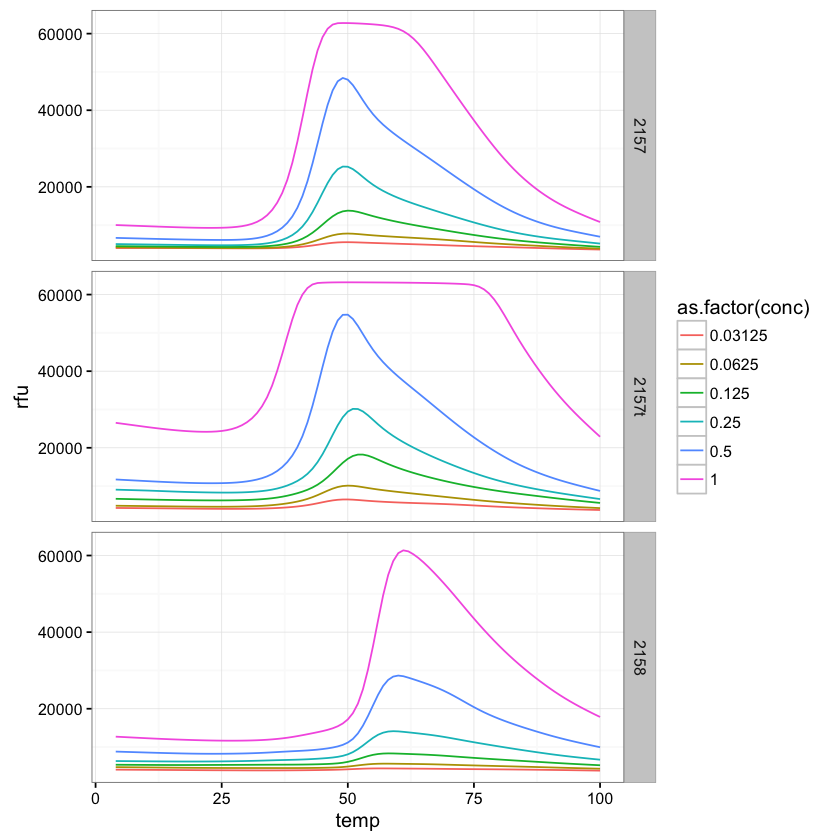

In [3]:
data %>% ggplot(aes(x = temp, y = rfu, color = as.factor(conc))) +
    geom_line() +
    facet_grid(protein~.) + 
    theme_bw()

This graph plots the raw data for the three proteins in the example file.  Protein concentrations are given in mg/L.  For the 2157 protein, both a truncated variant (`2157t`) and a full-length version (`2157`) were analyzed.  Because they show remarkably similar behavior, henceforth only the full-length data is analyzed.

# Simulating mixtures of two proteins when total protein is held constant

Guidelines from domain experts are to choose the data at the lowest concentration were reliable signal is still observed.  We choose 0.0626 g/L here.

In [4]:
starting_data <-
    data %>% filter(`conc` == 0.0625, `protein` %in% c('2157', '2158')) %>% 
        spread(protein, rfu)

starting_data %>% write.csv(file = 'starting_data_for_mixing_model.csv')

We've filtered away all the data on the truncated protein `2157t` and discarded all data not at our desired concentration.

Now we are ready to simulate mixtures of the data.  We define 20 points of interest along this mixing curve, specifically `0, 0.05, 0.1, ... 0.95, 1` representing 0%, 5%, 10%, ... 95%, and 100% of the protein being `2157`.  The simulated data is just a composition-weighted average of the data for the pure proteins.

In [6]:
mixing_frac <- 0:20/20

for(frac in mixing_frac){
    new_col <- paste('mix_2157_', frac, sep = '')
    mixture[, new_col] <- frac*mixture$`2157` + (1-frac)*mixture$`2158`
}

mixture.long <- 
    mixture %>%
        group_by(temp, conc) %>% 
        select(matches('mix')) %>% 
        gather(condition, rfu, `mix_2157_0`:`mix_2157_1`)

Adding missing grouping variables: `temp`, `conc`


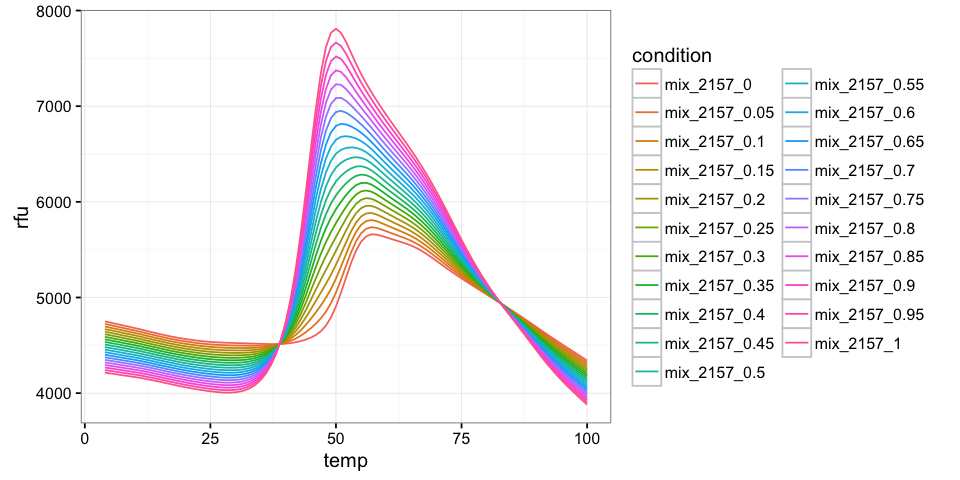

In [10]:
options(repr.plot.width = 8, repr.plot.height = 4)
mixture.long %>%
    ggplot(aes(x = temp, y = rfu, color = condition)) +
        geom_line() +
        theme_bw()

The _maximum_ fluorescence value is different for the two proteins.  Proteins of a different size and hydrophobicity should be expected to have different dye-binding capacities.  However, our assessment of melting temperature is the _inflection point_ of the simulated data.

Finding the inflection point requires numerical differentiation of the data.  Here, we approximate the first derivative using a [Savitsky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter).  This filtration helps remove high-frequency noise and smooth the data.  

From the (negative of) the SG-approximated first derivative, we simply find the data point that has the minimal value.  A better approach would be to fit the simulated data and find the true minimum on the fitted curve, but this approach is probably sufficient for making general points on the expected behavior of a mixture of non-interacting proteins.

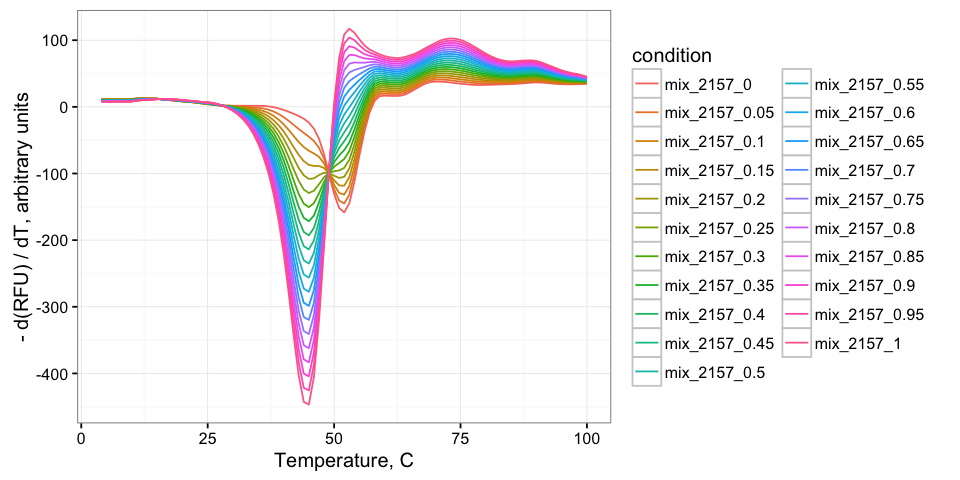

In [14]:
options(repr.plot.width = 8, repr.plot.height = 4)
derivs <- 
    mixture %>% 
    ungroup() %>% 
    mutate_at(.cols = vars(matches('mix')),
              .funs = funs({-sgolayfilt(., m=1, p=3, n=5)})
                      ) %>%
    group_by(temp, conc)

derivs.long <-
    derivs %>% gather(condition, deriv, matches('mix'))

derivs.long %>% 
    ggplot(aes(x = temp, y = deriv, color = condition)) +
        geom_line() + 
        theme_bw() +
        xlab('Temperature, C') +
        ylab('- d(RFU) / dT, arbitrary units')

In [38]:
melting.temps <- 
    derivs.long %>% 
        group_by(condition) %>%
        summarize(min_deriv = min(deriv), melting_temp = temp[deriv==min_deriv]) %>%
        separate(condition, c('foo', 'goo', 'fraction_2157'), sep = '_') %>%
        mutate(fraction_2157 = fraction_2157 %>% as.numeric) %>%
        select(-foo, -goo) 

melting.temps

,fraction_2157,min_deriv,melting_temp
1,0.0000,-158.3481,52.0000
2,0.0500,-145.0021,52.0000
3,0.1000,-131.6561,52.0000
4,0.1500,-118.3101,52.0000
5,0.2000,-108.1776,45.0000
6,0.2500,-129.3363,45.0000
7,0.3000,-150.4951,45.0000
8,0.3500,-171.6539,45.0000
9,0.4000,-192.8127,45.0000
10,0.4500,-213.9714,45.0000


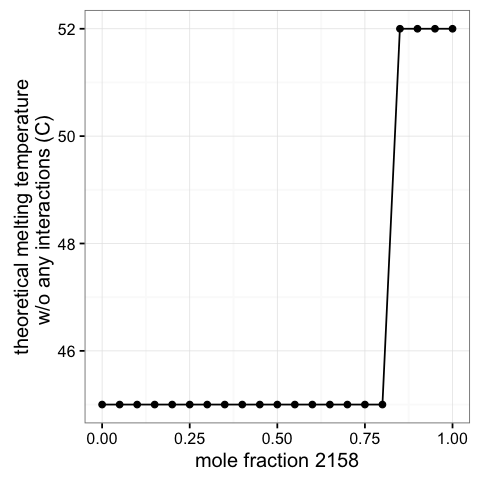

In [39]:
options(repr.plot.width = 4, repr.plot.height = 4)

melting.temps %>%
    ggplot(aes(x = 1-fraction_2157, y = melting_temp)) +
        geom_point() +
        geom_line() + 
        theme_bw() +
        xlab('mole fraction 2158') +
        ylab('theoretical melting temperature\nw/o any interactions (C) ')

Mixtures of non-interacting proteins that are held at constant total-protein-concentration are thus predicted to exhibit a _near binary-switch_ in calculated melting temperatures.  The switchover point is determined by the relative fluorescence intensity of the two proteins.

# Real melting temperatures as a function of protein concentration

This data also makes it possible to look at the melting temperature as a function of concentration.  This time we're only using real data, not simulated data.

In [ ]:
data %>% ggplot(aes(x = temp, y = rfu, color = as.factor(conc))) +
    geom_line() +
    facet_grid(protein~.) + 
    theme_bw()

In [34]:
derivs.by.conc <- 
    data %>% 
        unite(condition, protein, conc, sep = '_') %>%
        spread(condition, rfu) %>%
        ungroup() %>%
        mutate_at(.cols = vars(matches('215')),
                  .funs = funs({-sgolayfilt(., m=1, p=3, n=5)})
                  ) %>%
        group_by(temp) %>%
        gather(condition, deriv.val, -temp) %>% 
        separate(condition, c('protein', 'conc'), sep = '_')


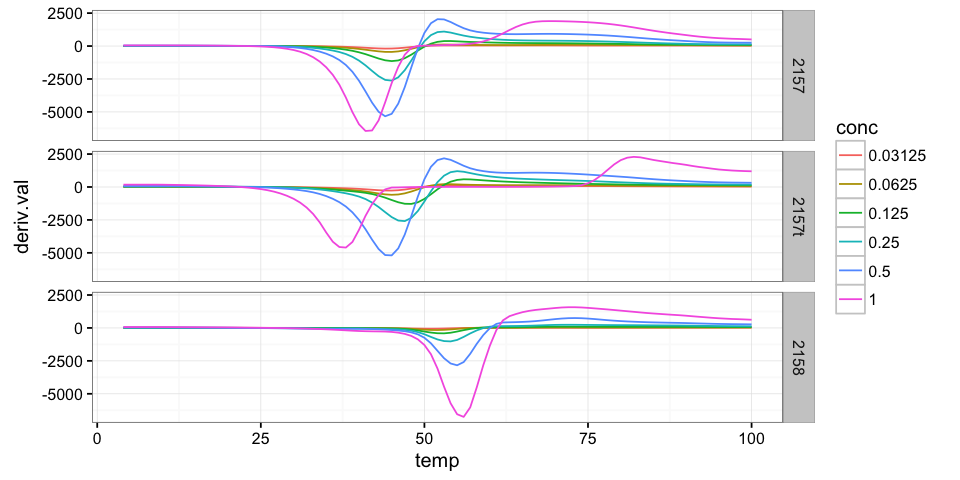

In [37]:
derivs.by.conc %>% 
    ggplot(aes(x = temp, y = deriv.val, color = conc)) +
        geom_line() +
        facet_grid(protein~.) +
        theme_bw()
    

In [44]:
melting.temps.by.conc <- 
    derivs.by.conc %>%
        group_by(protein, conc) %>%
        summarize(min_deriv = min(deriv.val), melting_temp = temp[deriv.val==min_deriv])

melting.temps.by.conc

,protein,conc,min_deriv,melting_temp
1,2157,0.03125,-192.695458170572,44
2,2157,0.0625,-446.718006184895,45
3,2157,0.125,-1142.59021321614,45
4,2157,0.25,-2623.11123209638,45
5,2157,0.5,-5331.23697265624,44
6,2157,1,-6447.2852115886,41
7,2157t,0.03125,-270.411502278651,45
8,2157t,0.0625,-592.131835937504,45
9,2157t,0.125,-1284.6146484375,48
10,2157t,0.25,-2589.49449544276,47


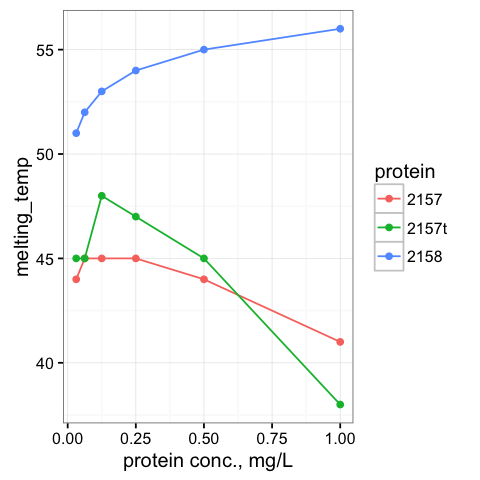

In [45]:
melting.temps.by.conc %>%
    ggplot(aes(x = conc %>% as.character %>% as.numeric, y = melting_temp, color = protein)) +
        geom_line() +
        geom_point() +
        theme_bw() +
        xlab('protein conc., mg/L')

This plot shows very interesting behavior for `2158`.  This protein has a lower melting temperature at lower concentrations.  One interpretation is that at higher concentrations, homodimerization or homooligomerization is favored, and that oligomerized states of the protein are more resistant to thermal denaturation.

The opposite behavior is seen for `2157`.  That imples no homooligomerization or even negative interactions between two molecules of 2157.  

The truncated mutant does show distinct properties from the full-length protein by this analysis, even discounting the data at 1 mg/L.  The truncated protein shows perhaps greater stability, as indicated by its higher melting temperatures at nearly every concentration tested.